<a href="https://colab.research.google.com/github/HarshRangwala/NeuralNetworkProjects/blob/master/Traffic_Signal_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [0]:
#Data loading 
import pickle
train_file = r"/content/drive/My Drive/Colab Notebooks/test.p" 
test_file = r"/content/drive/My Drive/Colab Notebooks/test.p"
val_file = r"/content/drive/My Drive/Colab Notebooks/valid.p"

with open(train_file, mode='rb') as f:
    train = pickle.load(f)
with open(val_file, mode='rb') as f:
    valid = pickle.load(f)
with open(test_file, mode='rb') as f:
    test = pickle.load(f)

In [0]:
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [0]:
import pandas as pd
import numpy as np

In [6]:
# Number of training examples
n_train = X_train.shape[0]

# Number of testing examples
n_test = X_test.shape[0]

# Number of validation examples.
n_validation = X_valid.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples: ", n_train)
print("Number of testing examples: ", n_test)
print("Number of validation examples: ", n_validation)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples:  12630
Number of testing examples:  12630
Number of validation examples:  4410
Image data shape = (32, 32, 3)
Number of classes = 43


In [0]:
def normalize(x):
    return (x.astype(float) - 128) / 128

In [0]:
import pandas as pd
import numpy as np

#converting to numpy arrays

xtrain = np.array(X_train)
ytrain = np.array(y_train)
xvalid = np.array(X_valid)
yvalid = np.array(y_valid)
xtest = np.array(X_test)
ytest = np.array(y_test)



np.shape(xtrain)
#preprocessing data

xtrain_norm = normalize(xtrain)
xtest_norm = normalize(xtest)
xvalid_norm = normalize(xvalid)

xtrain_norm = xtrain_norm.transpose((0, 3, 1, 2))
xtest_norm = xtest_norm.transpose((0, 3, 1, 2))
xvalid_norm = xvalid_norm.transpose((0, 3, 1, 2))

In [0]:
from __future__ import print_function, division
import os
import torch
import torch.nn as nn
#from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.autograd import Variable

In [0]:
xtrainTensor = torch.from_numpy(xtrain_norm)
xtestTensor = torch.from_numpy(xtest_norm)
xvalidTensor = torch.from_numpy(xvalid_norm)

ytrainTensor = torch.from_numpy(ytrain).long()
ytestTensor = torch.from_numpy(ytest).long()
yvalidTensor = torch.from_numpy(yvalid).long()

In [0]:
import torch.utils.data as utils

#creating tensor datasets
train_dataset = utils.TensorDataset(xtrainTensor, ytrainTensor) # create your datset
test_dataset = utils.TensorDataset(xtestTensor, ytestTensor)
valid_dataset = utils.TensorDataset(xvalidTensor, yvalidTensor)

In [0]:
#creating loaders

batch_size = 128

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = valid_dataset,
                                        batch_size = batch_size,
                                        shuffle = False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [0]:
# Project name used for jovian.commit
project_name = 'german-traffic-signal-recognition-feedforward'

## Base Model class & Training on GPU

Let's create a base model class, which contains everything except the model architecture i.e. it wil not contain the `__init__` and `__forward__` methods. We will later extend this class to try out different architectures. In fact, you can extend this model to solve any image classification problem.

In [0]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [0]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels.long()) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels.long())   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

We can also use the exact same training loop as before. I hope you're starting to see the benefits of refactoring our code into reusable functions.

In [0]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Finally, let's also define some utilities for moving out data & labels to the GPU, if one is available.

In [36]:
torch.cuda.is_available()

True

In [0]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [38]:
device = get_default_device()
device

device(type='cuda')

In [0]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, dtype = torch.float, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Let us also define a couple of helper functions for plotting the losses & accuracies.

In [0]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

In [0]:

def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

Let's move our data loaders to the appropriate device.

In [0]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

## Training the model

We will make several attempts at training the model. Each time, try a different architecture and a different set of learning rates. Here are some ideas to try:
- Increase or decrease the number of hidden layers
- Increase of decrease the size of each hidden layer
- Try different activation functions
- Try training for different number of epochs
- Try different learning rates in every epoch

What's the highest validation accuracy you can get to? **Can you get to 50% accuracy? What about 60%?**

In [0]:

input_size = 3*32*32
output_size = 43


**Q: Extend the `ImageClassificationBase` class to complete the model definition.**

Hint: Define the `__init__` and `forward` methods.

In [65]:
class trafficsignalModel(ImageClassificationBase):

  def __init__(self):
    super().__init__()
    self.linear1 = nn.Linear(input_size, 1324)
    self.linear2 = nn.Linear(1324, 500)
    self.linear3 = nn.Linear(500, 256)
    self.linear4 = nn.Linear(256, 128)
    self.linear5 = nn.Linear(128, 64)
    self.linear6 = nn.Linear(64, output_size)

  def forward(self, xb):
    #flatten the images
    # Flatten images into vectors
    out = xb.view(xb.size(0), -1)
    # Apply layers & activation functions
    out = self.linear1(out)
    out = F.relu(out)
    out = self.linear2(out)
    out = F.relu(out)
    out = self.linear3(out)
    out = F.relu(out)
    out = self.linear4(out)
    out = F.relu(out)
    out = self.linear5(out)
    out = F.relu(out)
    out = self.linear6(out)
    out = F.relu(out)
    return out
'''
  def __init__(self):
    #super(trafficsignalModel, self).__init__()
    super().__init__()
    self.conv1 = nn.Conv2d(3, 10, kernel_size = 5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size = 5)
    self.conv2_drop = nn.Dropout2d()
    self.fc1 = nn.Linear(500, 50)
    self.fc2 = nn.Linear(50, output_size)
  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
    x = x.view(-1, 500)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, training=self.training)
    x = self.fc2(x)
    return F.log_softmax(x)

  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1)
    self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
    self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
    self.fc1 = nn.Linear(4*4*64, 500)
    self.dropout1 = nn.Dropout(0.5)
    self.fc2 = nn.Linear(500, output_size)
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x, 2, 2)
    x = x.view(-1, 4*4*64)
    x = F.relu(self.fc1(x))
    x = self.dropout1(x)
    x = self.fc2(x)
    return x
'''

'\n  def __init__(self):\n    #super(trafficsignalModel, self).__init__()\n    super().__init__()\n    self.conv1 = nn.Conv2d(3, 10, kernel_size = 5)\n    self.conv2 = nn.Conv2d(10, 20, kernel_size = 5)\n    self.conv2_drop = nn.Dropout2d()\n    self.fc1 = nn.Linear(500, 50)\n    self.fc2 = nn.Linear(50, output_size)\n  def forward(self, x):\n    x = F.relu(F.max_pool2d(self.conv1(x), 2))\n    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))\n    x = x.view(-1, 500)\n    x = F.relu(self.fc1(x))\n    x = F.dropout(x, training=self.training)\n    x = self.fc2(x)\n    return F.log_softmax(x)\n\n  def __init__(self):\n    super().__init__()\n    self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1)\n    self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)\n    self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)\n    self.fc1 = nn.Linear(4*4*64, 500)\n    self.dropout1 = nn.Dropout(0.5)\n    self.fc2 = nn.Linear(500, output_size)\n  def forward(self, x):\n    x = F.relu(self.conv1(x))\n    x = F

You can now instantiate the model, and move it the appropriate device.

In [0]:
model = to_device(trafficsignalModel(), device)

Before you train the model, it's a good idea to check the validation loss & accuracy with the initial set of weights.

In [77]:
history = [evaluate(model, val_loader)]
history

[{'val_acc': 0.01495535671710968, 'val_loss': 3.7624144554138184}]

**Q: Train the model using the `fit` function to reduce the validation loss & improve accuracy.**

Leverage the interactive nature of Jupyter to train the model in multiple phases, adjusting the no. of epochs & learning rate each time based on the result of the previous training phase.

In [78]:
history += fit(100, 0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 3.7546, val_acc: 0.0469
Epoch [1], val_loss: 3.7478, val_acc: 0.0469
Epoch [2], val_loss: 3.7417, val_acc: 0.0469
Epoch [3], val_loss: 3.7361, val_acc: 0.0469
Epoch [4], val_loss: 3.7311, val_acc: 0.0469
Epoch [5], val_loss: 3.7265, val_acc: 0.0469
Epoch [6], val_loss: 3.7223, val_acc: 0.0469
Epoch [7], val_loss: 3.7185, val_acc: 0.0469
Epoch [8], val_loss: 3.7148, val_acc: 0.0469
Epoch [9], val_loss: 3.7112, val_acc: 0.0469
Epoch [10], val_loss: 3.7074, val_acc: 0.0469
Epoch [11], val_loss: 3.7030, val_acc: 0.0480
Epoch [12], val_loss: 3.6979, val_acc: 0.0518
Epoch [13], val_loss: 3.6927, val_acc: 0.0580
Epoch [14], val_loss: 3.6854, val_acc: 0.0632
Epoch [15], val_loss: 3.6767, val_acc: 0.0712
Epoch [16], val_loss: 3.6661, val_acc: 0.0708
Epoch [17], val_loss: 3.6537, val_acc: 0.0679
Epoch [18], val_loss: 3.6406, val_acc: 0.0632
Epoch [19], val_loss: 3.6290, val_acc: 0.0846
Epoch [20], val_loss: 3.6211, val_acc: 0.0748
Epoch [21], val_loss: 3.6155, val_acc: 0.074

In [81]:
history += fit(50, 0.03, model, train_loader, val_loader)

Epoch [0], val_loss: 3.2928, val_acc: 0.6190
Epoch [1], val_loss: 3.3246, val_acc: 0.6185
Epoch [2], val_loss: 3.3106, val_acc: 0.6239
Epoch [3], val_loss: 3.3611, val_acc: 0.6254
Epoch [4], val_loss: 3.4165, val_acc: 0.6289
Epoch [5], val_loss: 3.4376, val_acc: 0.6132
Epoch [6], val_loss: 3.4102, val_acc: 0.6288
Epoch [7], val_loss: 3.3336, val_acc: 0.6223
Epoch [8], val_loss: 3.2738, val_acc: 0.6194
Epoch [9], val_loss: 3.3281, val_acc: 0.6239
Epoch [10], val_loss: 3.3847, val_acc: 0.6027
Epoch [11], val_loss: 3.3474, val_acc: 0.6272
Epoch [12], val_loss: 3.3905, val_acc: 0.6241
Epoch [13], val_loss: 3.4171, val_acc: 0.6226
Epoch [14], val_loss: 3.4966, val_acc: 0.6190
Epoch [15], val_loss: 3.4176, val_acc: 0.6301
Epoch [16], val_loss: 3.4965, val_acc: 0.6202
Epoch [17], val_loss: 3.5002, val_acc: 0.6308
Epoch [18], val_loss: 4.4388, val_acc: 0.5425
Epoch [19], val_loss: 3.0969, val_acc: 0.6201
Epoch [20], val_loss: 3.3750, val_acc: 0.5869
Epoch [21], val_loss: 3.1310, val_acc: 0.631

In [82]:
history += fit(10, 0.03, model, train_loader, val_loader)

Epoch [0], val_loss: 3.4281, val_acc: 0.6310
Epoch [1], val_loss: 3.4691, val_acc: 0.6339
Epoch [2], val_loss: 3.4998, val_acc: 0.6322
Epoch [3], val_loss: 3.5282, val_acc: 0.6317
Epoch [4], val_loss: 3.6121, val_acc: 0.6259
Epoch [5], val_loss: 3.5813, val_acc: 0.6348
Epoch [6], val_loss: 3.5320, val_acc: 0.6378
Epoch [7], val_loss: 3.5688, val_acc: 0.6362
Epoch [8], val_loss: 3.5694, val_acc: 0.6394
Epoch [9], val_loss: 3.6163, val_acc: 0.6362


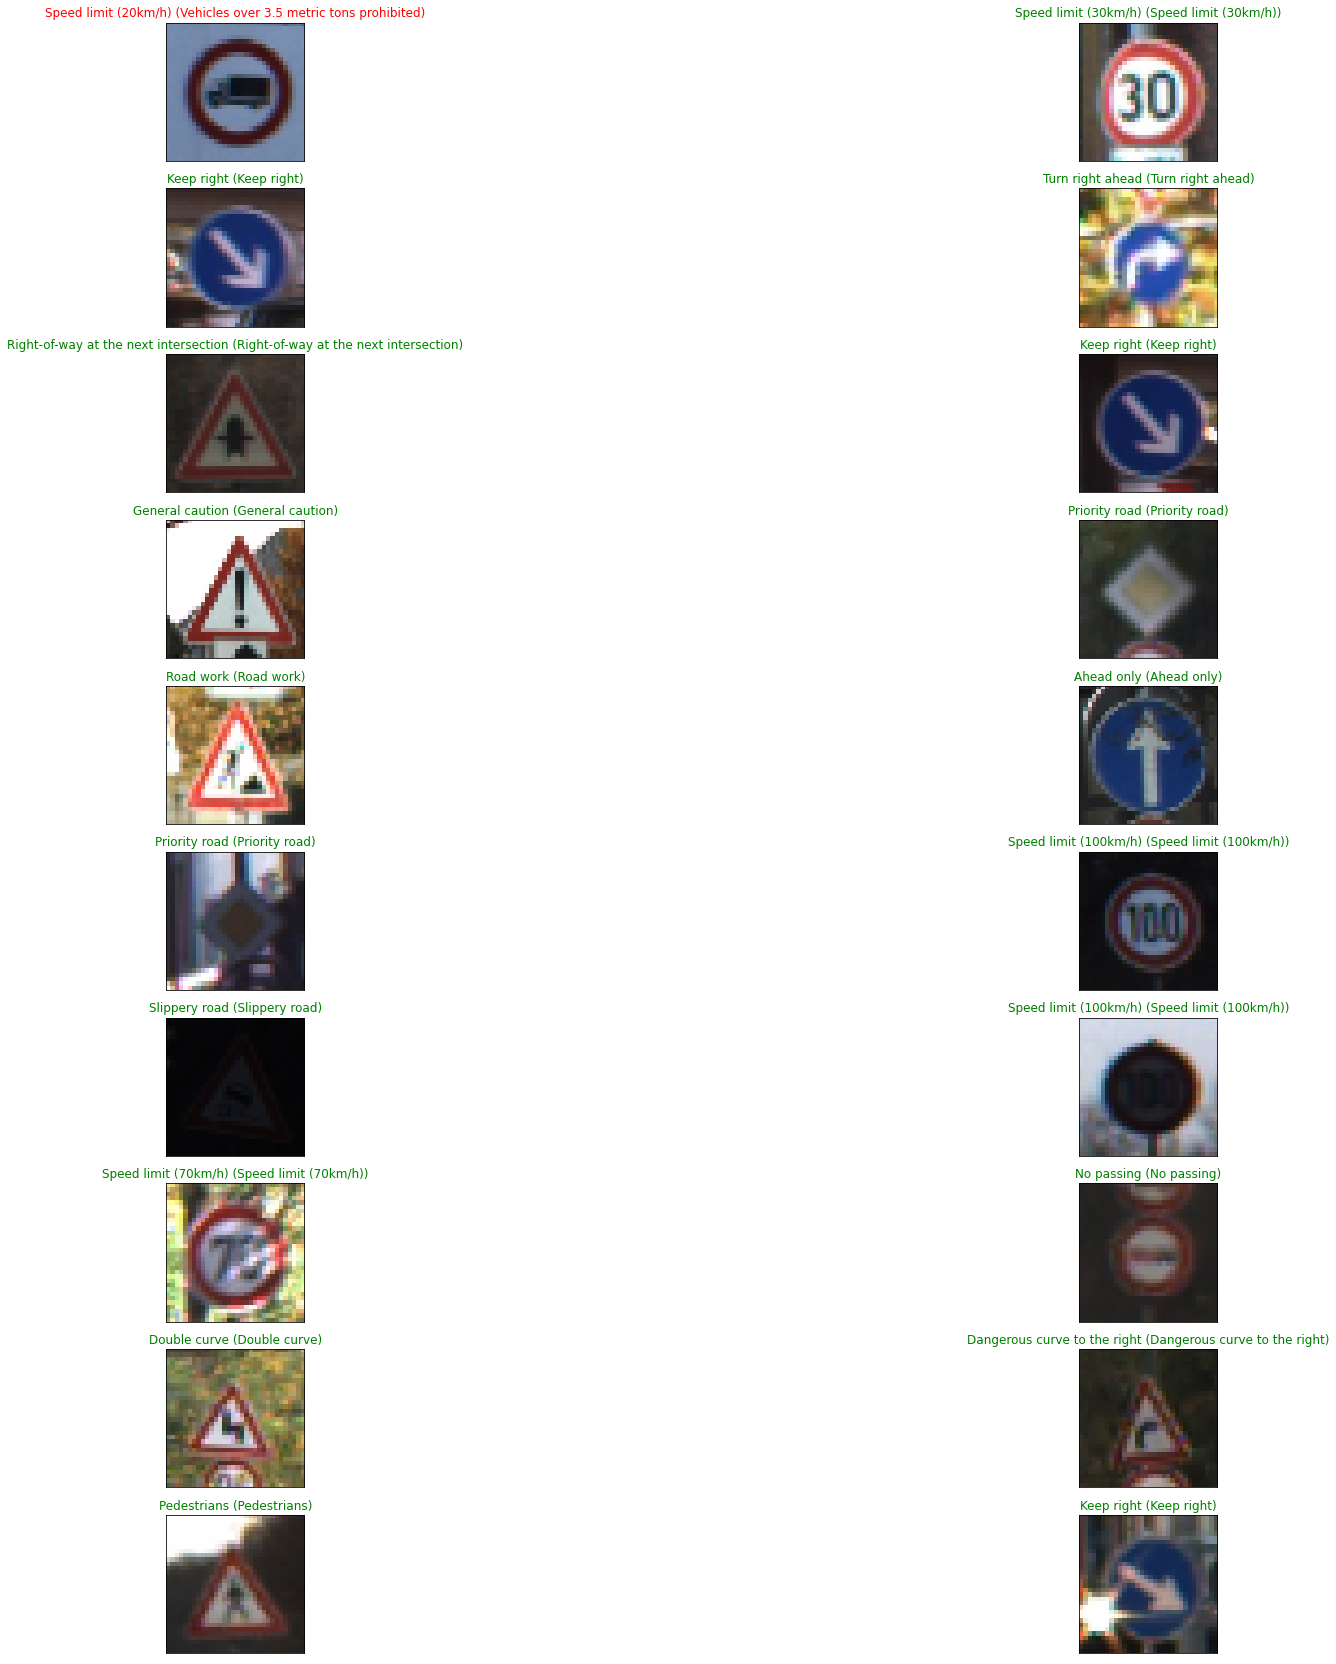

In [83]:
import numpy as np
import os
import csv
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

'''
classes = (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42)
'''

'''classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14',
           '15', '16', '17', '18', '19','20', '21', '22', '23', '24', '25', '26', '27', '28', '29',
           '30', '31', '32', '33', '34', '35', '36', '37', '38', '39','41','42')'''

with open('/content/signnames.csv', mode='r') as f:
    fread = csv.reader(f)
    next(fread, f)
    classes = [rows[1] for rows in fread]

dataiter = iter(test_loader)

images, labels = next(dataiter)
images = to_device(images, device)
labels = to_device(labels, device)

output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(30, 30))

for idx in np.arange(20):
  ax = fig.add_subplot(10, 2, idx+1, xticks=[], yticks=[] )
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[int(preds[idx].item())]), str(classes[int(labels[idx].item())])), color=("green" if preds[idx]==labels[idx] else "red"))

In [84]:
model.eval()
correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images.cuda())
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted.cpu() == labels.cpu()).sum()
print('Test Accuracy of the model on the 10000 test images: %.4f %%' % (100 * correct / total))

Test Accuracy of the model on the 10000 test images: 97.0000 %


/pytorch/aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


RuntimeError: ignored

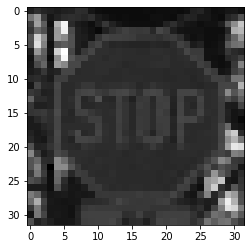

In [85]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  #image = image.transpose(1, 2, 0)
  #image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  #image = image.clip(0, 1)
  return image

img, label = test_dataset[1533]
img = to_device(img, device)
label = to_device(label, device)
plt.imshow(im_convert(img[0]), cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

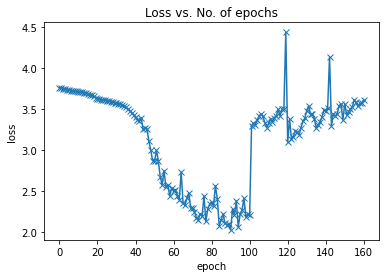

In [86]:
plot_losses(history)

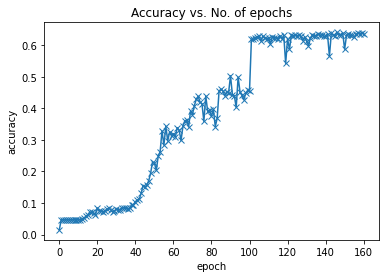

In [87]:
plot_accuracies(history)

In [0]:
model_architecture = repr(model)

In [89]:
model_architecture

'trafficsignalModel(\n  (linear1): Linear(in_features=3072, out_features=1324, bias=True)\n  (linear2): Linear(in_features=1324, out_features=500, bias=True)\n  (linear3): Linear(in_features=500, out_features=256, bias=True)\n  (linear4): Linear(in_features=256, out_features=128, bias=True)\n  (linear5): Linear(in_features=128, out_features=64, bias=True)\n  (linear6): Linear(in_features=64, out_features=43, bias=True)\n)'